In [1]:
#! pip install Geopandas
#!pip install --use-deprecated=legacy-resolver pycaret[full]
#!pip install pycaret[full]

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import os.path


import seaborn as sns
from scipy import stats


# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.pyplot import *
import imageio
from skimage.io import imread

from tqdm import tqdm

import cv2   #For image processing

import tensorflow as tf
#All tensorflow utilities for creating, training and working with a CNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


import sklearn
from sklearn.preprocessing import LabelEncoder    #For encoding categorical variables
from sklearn.model_selection import train_test_split #For splitting of data
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv, rgba2rgb
from skimage.morphology import area_opening
from skimage.exposure import histogram
from skimage.filters import threshold_otsu
from skimage import io, color

from pycaret.datasets import get_data
from pycaret.regression import *

In [3]:
#set directory for csv files
dir_name = r'C:\Users\vasan\OneDrive\EmissionsDatathon\Zeroing Methane Emissions - Dataset'
filename_suffix = 'xls'

In [4]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_excel("datamodel.xlsx", thousands=',', skiprows = skiprows)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

,source_id,source_lat,source_lon,source_type_y,ipcc,number_overflights,source_persistence,confidence_in_persistence,qsource,sigma_qsource,Filepath,Name,candidate_id,plume_lat,plume_lon,date,qplume,sigma_qplume,Uncern
0,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-2_r4578_c217-plume.png,ang20190922t192642-2,32.212063,-103.697076,2019-09-22,2579.528100,902.732655,133.151448
1,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190923t163307-G_r4113_c198-plume.png,ang20190923t163307-G,32.212117,-103.697086,2019-09-23,934.430300,276.716131,736.942230
2,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190926t223557-D_r4139_c225-plume.png,ang20190926t223557-D,32.212162,-103.696830,2019-09-26,443.098484,152.257940,110.191596
3,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20191006t150453-6_r4168_c237-plume.png,ang20191006t150453-6,32.212327,-103.697526,2019-10-06,1032.395030,606.623335,244.327697
4,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20191007t182352-2_r4062_c150-plume.png,ang20191007t182352-2,32.212253,-103.697253,2019-10-07,826.823256,226.851094,135.781536


In [5]:
df.describe()

,source_lat,source_lon,number_overflights,source_persistence,qsource,sigma_qsource,plume_lat,plume_lon,qplume,sigma_qplume,Uncern
count,6062.000000,6062.000000,6062.000000,6062.000000,6062.000000,6062.000000,6062.000000,6062.000000,6062.000000,6062.000000,5990.000000
mean,33.062778,-104.179228,5.185087,0.551059,305.836566,100.361834,33.062778,-104.179227,559.042147,183.240800,71.067197
std,2.430492,7.096847,3.336843,0.315326,467.552992,155.206428,2.430492,7.096847,797.892685,269.671393,166.995204
min,25.857711,-122.412006,1.000000,0.071429,2.697304,0.625286,25.857300,-122.412006,8.091911,4.246207,0.450500
25%,31.822890,-104.097143,3.000000,0.285714,74.051119,24.749421,31.822863,-104.097101,166.331086,54.947155,22.537497
50%,32.066110,-103.737620,4.000000,0.500000,159.948436,54.200015,32.066123,-103.737790,307.209799,103.020765,36.563889
75%,32.558432,-103.032393,9.000000,0.857143,325.974110,110.156066,32.558554,-103.032501,615.901103,202.875586,59.994311
max,42.281528,-75.581762,14.000000,1.000000,5316.639288,2168.145498,42.281596,-75.581762,16811.280200,8519.241420,5363.490487


In [6]:
def image_processing(fil):
    # Open image and import it as a numpy array
    im2 = imread(fil)
    im2_rgb = color.rgba2rgb(im2)
    im2_hsv = rgb2hsv(im2_rgb)
    
    mask = im2_hsv[:,:,1] > 0.4
    
    red = im2[:,:,0]*mask
    green = im2[:,:,1]*mask
    blue = im2[:,:,2]*mask
    
    flat_red = red.flatten()
    flat_green = green.flatten()
    flat_blue = blue.flatten()
    
    nonzero_red = flat_red[flat_red != 0]
    nonzero_green = flat_green[flat_green != 0]
    nonzero_blue = flat_blue[flat_blue != 0]
    
    meanr = np.mean(nonzero_red)
    meang = np.mean(nonzero_green)
    meanb = np.mean(nonzero_blue)
    
    filename = fil.split("/")[-1]
    
    return (meanr, meang, meanb)

In [7]:
meanr_list = []
meang_list = []
meanb_list = []
name_list = []
qplume = []

In [8]:
for file in tqdm(df['Filepath'].tolist()[:]):
    meanr, meang, meanb = image_processing(file)
    meanr_list.append(meanr)
    meang_list.append(meang)
    meanb_list.append(meanb)
    name_list.append(os.path.basename(file))  # add filename to list

100%|██████████| 6062/6062 [01:52<00:00, 54.00it/s]


In [9]:
dfeat = pd.DataFrame({'Red': meanr_list, 'Green': meang_list, 'Blue': meanb_list, 'Name': name_list})

In [10]:
dfeat.head()

,Red,Green,Blue,Name
0,181.358816,47.365528,58.732138,ang20190922t192642-2_r4578_c217-plume.png
1,163.016873,116.526079,86.684041,ang20190923t163307-G_r4113_c198-plume.png
2,148.860910,65.633528,55.371571,ang20190926t223557-D_r4139_c225-plume.png
3,195.260858,106.511460,97.770766,ang20191006t150453-6_r4168_c237-plume.png
4,175.007143,133.739831,96.091491,ang20191007t182352-2_r4062_c150-plume.png


In [11]:
dfeat3 = pd.merge(dfeat, df[['qplume', 'Name']], on='Name')

In [12]:
dfeat3.head()

,Red,Green,Blue,Name,qplume
0,181.358816,47.365528,58.732138,ang20190922t192642-2_r4578_c217-plume.png,2579.528100
1,163.016873,116.526079,86.684041,ang20190923t163307-G_r4113_c198-plume.png,934.430300
2,148.860910,65.633528,55.371571,ang20190926t223557-D_r4139_c225-plume.png,443.098484
3,195.260858,106.511460,97.770766,ang20191006t150453-6_r4168_c237-plume.png,1032.395030
4,175.007143,133.739831,96.091491,ang20191007t182352-2_r4062_c150-plume.png,826.823256


In [13]:
dfeat3.isna().sum()

Red         2
Green      10
Blue      365
Name        0
qplume      0
dtype: int64

In [14]:
dfeat3 = dfeat3.dropna()

In [15]:
dfeat3.shape

(5697, 5)

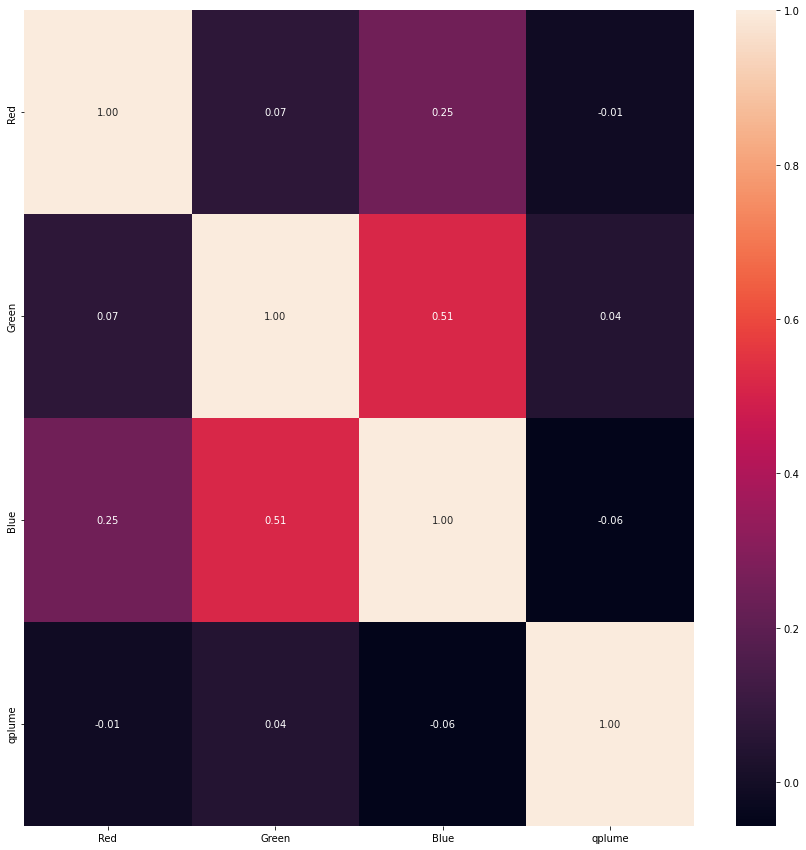

In [16]:
plt.figure(figsize=(15, 15))
ax = sns.heatmap(dfeat3.corr(), annot=True, fmt=".2f")

In [17]:
dfeat3.shape

(5697, 5)

In [18]:
dfeat3 = dfeat3.drop('Name', axis=1)

In [19]:
dfeat3.head()

,Red,Green,Blue,qplume
0,181.358816,47.365528,58.732138,2579.528100
1,163.016873,116.526079,86.684041,934.430300
2,148.860910,65.633528,55.371571,443.098484
3,195.260858,106.511460,97.770766,1032.395030
4,175.007143,133.739831,96.091491,826.823256


count     5697.000000
mean       580.827147
std        816.435878
min          8.091911
25%        174.692302
50%        320.523905
75%        642.015701
max      16811.280200
Name: qplume, dtype: float64


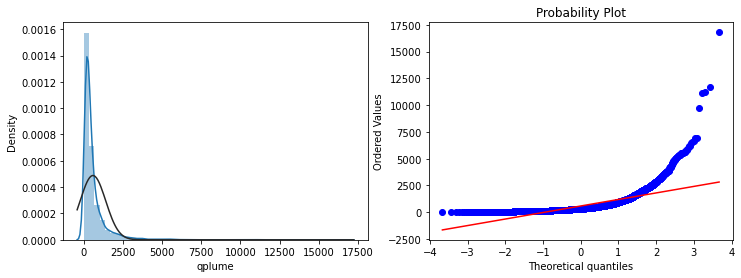

In [21]:
print(dfeat3.qplume.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(dfeat3.qplume.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(dfeat3.qplume.dropna(), plot=plt)

count    5697.000000
mean      169.035126
std        38.210885
min         1.450000
25%       155.384897
50%       180.074633
75%       194.595638
max       248.707987
Name: Red, dtype: float64


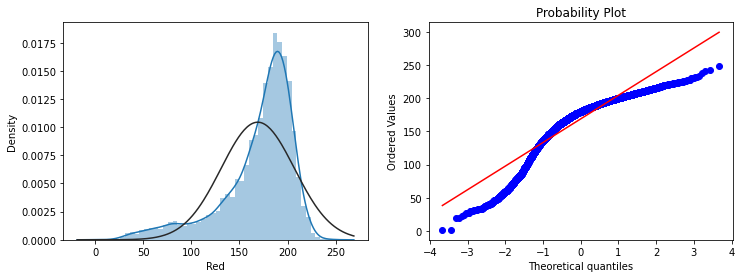

In [25]:
print(dfeat3.Red.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(dfeat3.Red.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(dfeat3.Red.dropna(), plot=plt)

count    5697.000000
mean       74.662838
std        47.373625
min         1.409091
25%        36.255287
50%        66.261205
75%       110.606061
max       255.000000
Name: Green, dtype: float64


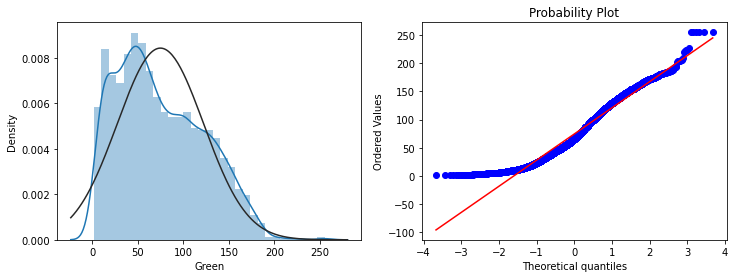

In [26]:
print(dfeat3.Green.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(dfeat3.Green.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(dfeat3.Green.dropna(), plot=plt)

count    5697.000000
mean       66.803252
std        30.043093
min         1.000000
25%        48.115942
50%        66.380952
75%        86.196429
max       213.000000
Name: Blue, dtype: float64


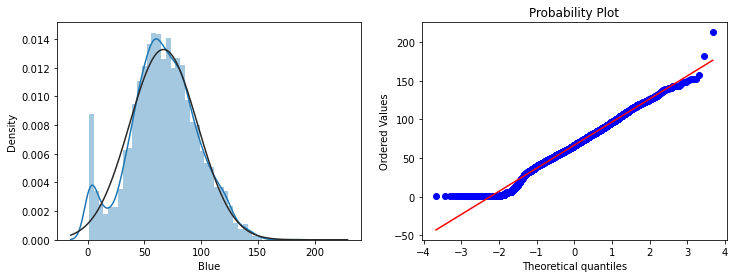

In [27]:
print(dfeat3.Blue.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(dfeat3.Blue.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(dfeat3.Blue.dropna(), plot=plt)

In [28]:
dfeat3['log_qplume'] = np.log(dfeat3['qplume'])

count    5697.000000
mean        5.836666
std         0.994061
min         2.090865
25%         5.163026
50%         5.769957
75%         6.464613
max         9.729805
Name: log_qplume, dtype: float64


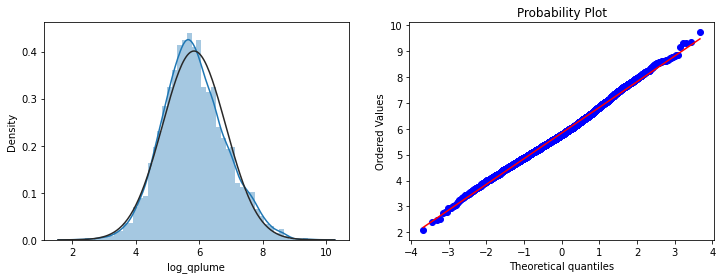

In [29]:
print(dfeat3.log_qplume.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(dfeat3.log_qplume.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(dfeat3.log_qplume.dropna(), plot=plt)

In [31]:
#dfeat3.to_excel("dfeat3all.xlsx")  

In [46]:
dfeat3 = dfeat3.drop('qplume', axis=1)

In [47]:
# Creates a mask where values that are true go into the training/test set
# Note that I done it so that the random number is predictable

msk = np.random.seed(0)
msk = np.random.rand(len(dfeat3))<0.8

dftrain = dfeat3[msk]
dftest = dfeat3[~msk]

print(dftrain.shape)
print(dftest.shape)

(4565, 4)
(1132, 4)


In [48]:
dftrain

,Red,Green,Blue,log_qplume
0,181.358816,47.365528,58.732138,7.855362
1,163.016873,116.526079,86.684041,6.839937
2,148.860910,65.633528,55.371571,6.093792
3,195.260858,106.511460,97.770766,6.939637
4,175.007143,133.739831,96.091491,6.717591
...,...,...,...,...
6056,189.310385,14.383008,64.230769,5.875203
6057,181.612364,58.960765,98.103226,7.348044
6058,185.030525,76.448276,95.907407,6.461527
6059,84.151522,45.405511,48.114750,6.083160


In [49]:
target_columns = [
    "log_qplume"
]

y_train = dftrain[target_columns]
X_train = dftrain.drop(columns=target_columns)

In [50]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [51]:
y_predtrain = model_lr.predict(X_train)

In [52]:
print('Coefficients:', model_lr.coef_)
print('Intercept:', model_lr.intercept_)

Coefficients: [[ 0.00078269  0.00203094 -0.00355786]]
Intercept: [5.79747597]


In [53]:
# Calculate the mean squared error
mse = mean_squared_error(y_train, y_predtrain)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)

r2 = r2_score(y_train, y_predtrain)
print("Test R^2 Score: {:.5f}".format(r2))

Root Mean Squared Error: 0.9784901176815591
Test R^2 Score: 0.01012


In [54]:
y_test = dftest[target_columns]
X_test= dftest.drop(columns=target_columns)

In [55]:
y_predtest = model_lr.predict(X_test)

In [56]:
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_predtest)

# Calculate the root mean squared error
rmset = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)

r2t = r2_score(y_test, y_predtest)
print("Test R^2 Score: {:.5f}".format(r2))

Root Mean Squared Error: 0.9784901176815591
Test R^2 Score: 0.01012


In [57]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
dfsub = pd.read_excel("dfsub.xlsx", thousands=',', skiprows = skiprows)
dfsub = dfsub.loc[:, ~dfsub.columns.str.contains('^Unnamed')] 
dfsub.head()

,Red,Green,Blue
0,94.390956,109.400125,179.221933
1,92.910174,111.842154,199.957061
2,110.781377,118.080972,188.804082
3,97.612245,97.132653,213.602041
4,94.207557,99.177906,211.434359


In [58]:
dfsub.shape

(20, 3)

In [59]:
y_predsub = model_lr.predict(dfsub)

In [60]:
y_predsub

array([[5.45589257],
       [5.38592046],
       [5.45225945],
       [5.31117968],
       [5.32038096],
       [5.30330345],
       [5.38603757],
       [5.30660329],
       [5.45124766],
       [5.90690689],
       [5.55982068],
       [5.55740024],
       [5.71416553],
       [5.30499006],
       [5.4061228 ],
       [5.6980962 ],
       [5.58980992],
       [5.73293893],
       [5.83239035],
       [5.7805033 ]])

In [61]:
y_predsubunlog = np.exp(y_predsub)

In [62]:
y_predsubunlog

array([[234.13375837],
       [218.3109587 ],
       [233.28466639],
       [202.58907715],
       [204.46175943],
       [200.99970748],
       [218.33652706],
       [201.66406976],
       [233.04875072],
       [367.56746719],
       [259.77624868],
       [259.14823625],
       [303.13114283],
       [201.33900054],
       [222.76620156],
       [298.29895704],
       [267.68473412],
       [308.87569837],
       [341.17322706],
       [323.92217875]])

In [64]:
np.savetxt('17c.csv', y_predsubunlog, delimiter=',')